# Fake News Classification — Classical ML Baseline
This notebook follows the provided outline to build and compare two classical machine learning models for fake news detection.

## 1. Introduction
We will explore the WELFake dataset to understand how traditional natural language processing pipelines can distinguish fake from real news. Each section starts with an explanation, followed by the associated code so the workflow stays easy to follow.

## 2. Dataset Loading
The first step is to import the libraries we will use and load the WELFake dataset into a pandas DataFrame. We will inspect the structure, preview the records, and check for missing values to confirm that the file loaded correctly.

In [15]:
# Core data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling utilities
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Text processing tools
import re
from sklearn.feature_extraction import text

try:
    from nltk.stem import PorterStemmer
except ImportError as exc:
    raise ImportError("nltk is required for stemming. Install it via 'pip install nltk'.") from exc

plt.style.use('seaborn-v0_8')
sns.set_context('talk', font_scale=0.8)
pd.set_option('display.max_colwidth', 200)

In [16]:
# Load the dataset and perform an initial inspection
DATA_PATH = 'WELFake_Dataset.csv'
df = pd.read_csv(DATA_PATH, encoding='utf-8', low_memory=False)

print('Rows:', len(df))
print('Columns:', df.columns.tolist())
print('Data types:')
print(df.dtypes)

print('Sample records:')
display(df.head())

print('Missing values per column:')
print(df.isna().sum())

Rows: 72134
Columns: ['Unnamed: 0', 'title', 'text', 'label']
Data types:
Unnamed: 0     int64
title         object
text          object
label          int64
dtype: object
Sample records:


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO],No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others o...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO],"Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Er...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid",A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled f...,0
4,4,SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice,"The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly ag...",1


Missing values per column:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


## 3. Data Preprocessing
We will combine relevant text fields, normalize and clean the text, drop unusable rows, and encode the target labels. Stemming and stop word removal help reduce noise before vectorization.

In [17]:
# Prepare text and label columns
possible_text_columns = ['title', 'text', 'content', 'article', 'body']
text_columns = [col for col in possible_text_columns if col in df.columns]
if not text_columns:
    raise ValueError('No text columns found. Please verify the dataset schema.')

label_candidates = ['label', 'class', 'target', 'fake']
label_cols = [col for col in label_candidates if col in df.columns]
if not label_cols:
    raise ValueError('No label column located. Please confirm the dataset contains a target label.')
label_col = label_cols[0]

df[text_columns] = df[text_columns].fillna('')
df[label_col] = df[label_col].fillna('')

def combine_text_columns(row):
    parts = [str(row[col]).strip() for col in text_columns if str(row[col]).strip()]
    return ' '.join(parts)

df['full_text'] = df.apply(combine_text_columns, axis=1)
df = df[df['full_text'].str.strip().astype(bool)]

df = df.drop_duplicates(subset=['full_text']).reset_index(drop=True)

# Encode labels to binary integers
if df[label_col].dtype == object:
    df[label_col] = df[label_col].str.lower().str.strip()
    label_mapping = {'fake': 0, 'false': 0, 'real': 1, 'true': 1}
    df[label_col] = df[label_col].replace(label_mapping)

df[label_col] = pd.to_numeric(df[label_col], errors='coerce')
df = df.dropna(subset=[label_col])
df[label_col] = df[label_col].astype(int)
df = df.rename(columns={label_col: 'label'})

print('Remaining rows after cleaning:', len(df))
df[['full_text', 'label']].head()

Remaining rows after cleaning: 63676


,full_text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] No comment is expected from Barack Obama Members of the #FYF911 o...,1
1,Did they post their votes for Hillary already?,1
2,"UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO] Now, most of the demonstrators gathered last night were ex...",1
3,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a c...",0
4,"SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec an...",1


In [18]:
# Normalize and stem the text
stop_words = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()

def clean_text(doc: str) -> str:
    doc = doc.lower()
    doc = re.sub(r'[^a-z]', ' ', doc)
    tokens = []
    for token in doc.split():
        if token in stop_words or len(token) <= 2:
            continue
        tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

df['processed_text'] = df['full_text'].apply(clean_text)
df = df[df['processed_text'].str.strip().astype(bool)]
processed_df = df[['processed_text', 'label']].reset_index(drop=True)
processed_df.head()

,processed_text,label
0,law enforc high alert follow threat cop white blacklivesmatt fyf terrorist video comment expect barack obama member fyf fukyoflag blacklivesmatt movement call lynch hang white peopl cop encourag r...,1
1,did post vote hillari,1
2,unbeliev obama attorney gener say charlott rioter peac protest home state north carolina video demonstr gather night exercis constitut protect right peac protest order rais issu creat chang lorett...,1
3,bobbi jindal rais hindu use stori christian convers woo evangel potenti bid dozen polit activ pastor came privat dinner friday night hear convers stori uniqu context presidenti polit louisiana gov...,0
4,satan russia unv imag terrifi new supernuk western world take notic sarmat missil dub satan replac fli mile sec rang mile weapon perceiv increasingli aggress russia deliv warhead megaton time powe...,1


## 4. Exploratory Data Analysis
We will examine the class distribution and highlight the most frequent terms after preprocessing to understand the dataset balance and vocabulary.

C:\Users\priya\AppData\Local\Temp\ipykernel_11332\4070975631.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_counts, x='Label', y='Count', palette='viridis', ax=ax)


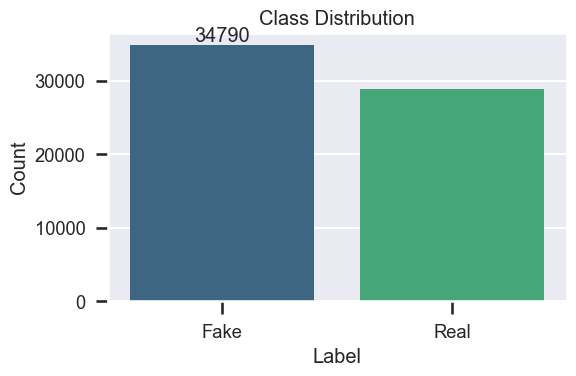

,Label,Count
0,Fake,34790
1,Real,28835


In [19]:
# Plot the class distribution
label_names = {0: 'Fake', 1: 'Real'}
class_counts = processed_df['label'].map(label_names).value_counts().reset_index()
class_counts.columns = ['Label', 'Count']

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=class_counts, x='Label', y='Count', palette='viridis', ax=ax)
ax.set_title('Class Distribution')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

class_counts

C:\Users\priya\AppData\Local\Temp\ipykernel_11332\723966564.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tokens_df, x='count', y='token', palette='mako', ax=ax)


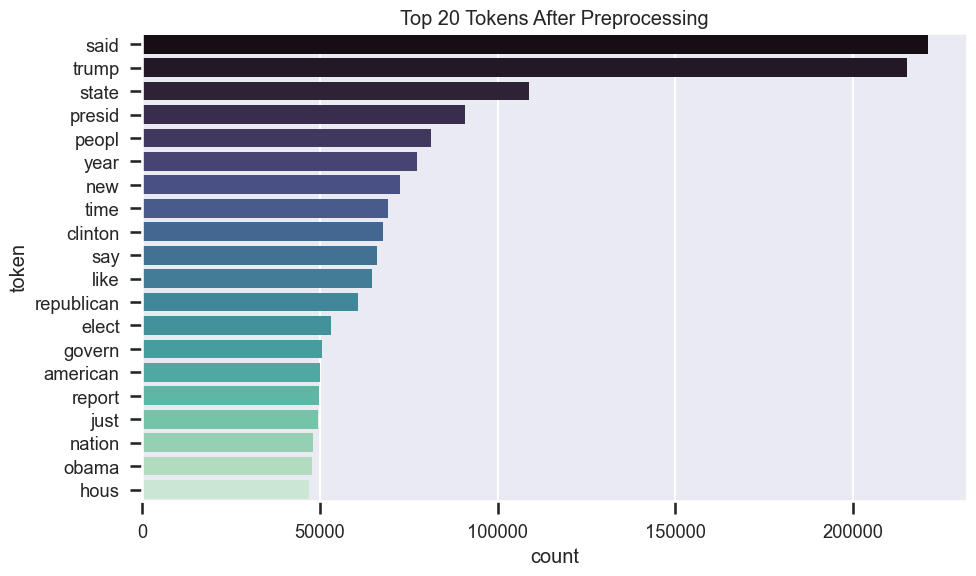

,token,count
0,said,220918
1,trump,215113
2,state,108758
3,presid,90853
4,peopl,81421
5,year,77465
6,new,72597
7,time,69266
8,clinton,67759
9,say,66208


In [20]:
# Display the most common stemmed tokens
from collections import Counter

token_counter = Counter()
processed_df['processed_text'].str.split().apply(token_counter.update)
top_tokens = token_counter.most_common(20)
top_tokens_df = pd.DataFrame(top_tokens, columns=['token', 'count'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=top_tokens_df, x='count', y='token', palette='mako', ax=ax)
ax.set_title('Top 20 Tokens After Preprocessing')
plt.tight_layout()
plt.show()

top_tokens_df

## 5. Train-Test Split
We will create a stratified split so both train and test sets maintain the original class balance.

In [21]:
# Prepare features and target, then create a stratified split
X = processed_df['processed_text']
y = processed_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 47718
Testing samples: 15907


## 6. Feature Extraction
We will transform the cleaned text into TF-IDF features using unigrams and bigrams. Limiting the vocabulary keeps the feature space manageable.

In [22]:
# Fit a TF-IDF vectorizer on the training data
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print('TF-IDF matrix shape (train):', X_train_tfidf.shape)
print('TF-IDF matrix shape (test):', X_test_tfidf.shape)

TF-IDF matrix shape (train): (47718, 5000)
TF-IDF matrix shape (test): (15907, 5000)


## 7. Model Training — Model 1 (Multinomial Naive Bayes)
We start with Multinomial Naive Bayes, a strong baseline for text classification problems thanks to its probabilistic assumptions over word counts.

In [23]:
# Train and predict with Multinomial Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
nb_pred = nb_clf.predict(X_test_tfidf)

## 8. Model Training — Model 2 (Logistic Regression)
Next, we train a logistic regression model that often performs well on sparse TF-IDF features when properly regularized.

In [24]:
# Train and predict with Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
log_reg.fit(X_train_tfidf, y_train)
lr_pred = log_reg.predict(X_test_tfidf)

## 9. Model Evaluation
We evaluate both models using accuracy, precision, recall, F1-score, and the full classification report.

In [25]:
# Gather evaluation metrics for both models
predictions = {
    'Multinomial Naive Bayes': nb_pred,
    'Logistic Regression': lr_pred
}

metrics = []
for name, preds in predictions.items():
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average='binary', zero_division=0
    )
    accuracy = accuracy_score(y_test, preds)
    metrics.append({
        'model': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    print(f"=== {name} ===")
    print(classification_report(y_test, preds, target_names=['Fake', 'Real'], zero_division=0))

metrics

=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

        Fake       0.87      0.84      0.85      8698
        Real       0.81      0.85      0.83      7209

    accuracy                           0.84     15907
   macro avg       0.84      0.84      0.84     15907
weighted avg       0.84      0.84      0.84     15907

=== Logistic Regression ===
              precision    recall  f1-score   support

        Fake       0.94      0.95      0.95      8698
        Real       0.94      0.93      0.93      7209

    accuracy                           0.94     15907
   macro avg       0.94      0.94      0.94     15907
weighted avg       0.94      0.94      0.94     15907



[{'model': 'Multinomial Naive Bayes',
  'accuracy': 0.8405104670899604,
  'precision': 0.8105557032704068,
  'recall': 0.8457483700929393,
  'f1': 0.8277781549114113},
 {'model': 'Logistic Regression',
  'accuracy': 0.9407179229270133,
  'precision': 0.9379368185630417,
  'recall': 0.9307809682341518,
  'f1': 0.9343451925085289}]

### Confusion Matrices
Confusion matrices help visualize how each model classifies fake and real articles.

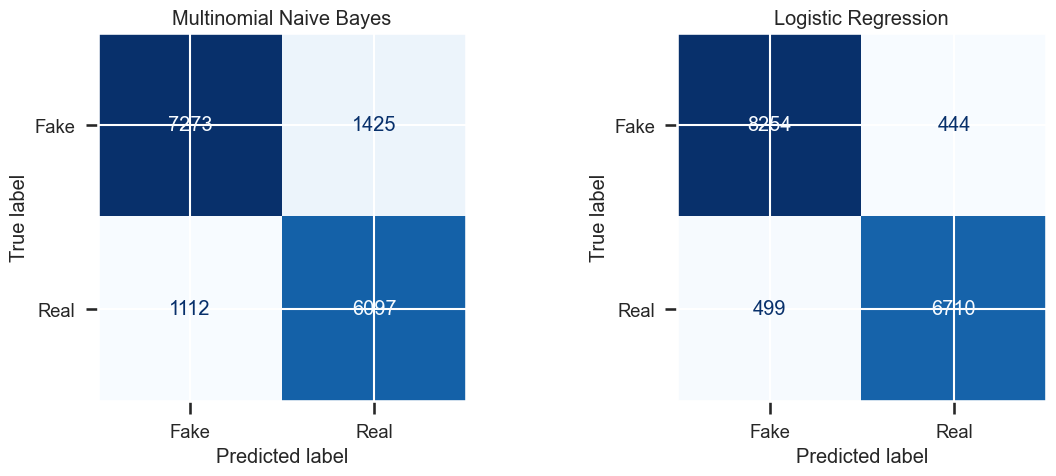

In [26]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, preds) in zip(axes, predictions.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=['Fake', 'Real'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(name)

plt.tight_layout()
plt.show()

## 10. Model Comparison
We summarize the evaluation metrics in a table to compare model performance at a glance.

In [27]:
# Summarize metrics in a comparison table
metrics_df = pd.DataFrame(metrics).set_index('model')
metrics_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1
model,,,,
Logistic Regression,0.940718,0.937937,0.930781,0.934345
Multinomial Naive Bayes,0.840510,0.810556,0.845748,0.827778


## 11. Conclusion
- **Performance:** Review the metric table to decide which model performed best. Logistic regression often edges out Naive Bayes on recall, while Naive Bayes can be faster.
- **Key observations:** Examine the confusion matrices and top tokens to understand typical errors or vocabulary patterns.
- **Next steps:** Consider richer features (character n-grams, embeddings), hyperparameter tuning, or deep learning models for improved accuracy.

## 12. Appendix
- **Experiment notes:** Track alternative preprocessing ideas (e.g., lemmatization, character n-grams, different stop-word lists) and log their impact on validation scores.
- **Hyperparameter tuning:** Record grid-search or randomized-search settings, including regularization strengths for logistic regression and smoothing values for Naive Bayes.
- **Extended models:** Consider benchmarking linear SVMs, ensemble methods, or transformer-based classifiers and summarize their relative performance.
- **Error analysis:** Save representative false positives and negatives for manual review to identify systematic failure modes.
- **Reference:** Ahmed et al., "Detecting Fake News on Social Media," IEEE ICWSM 2017.
- **Reference:** McIntire, "WELFake: Word Embedding Over Fake News," Kaggle Dataset.